# ПРАКТИКА 3. Алгоритмы кластеризации

Задание на сегодня состоит из двух частей. В первой части нужно реализовать базовые алгоритмы, которые рассказывались на лекции. Во второй части предлагается их немного улучшить.



## 1. Basic

### 1.1. K-Means

Реализуйте метод сжатия изображений в формате PNG с помощью кластеризации пикселей. 

Общая схема работы метода:

* С помощью алгоритма Ллойда построить по изображению набор из **K** базовых цветов. Базовый цвет -- это центроид в пространстве RGB.

* Преобразовать исходное изображение в новое, в котором каждый пиксель заменен на ближайший к нему базовый цвет.

Необходимо, чтобы преобразованное изображение визуально не сильно отличалось от исходного

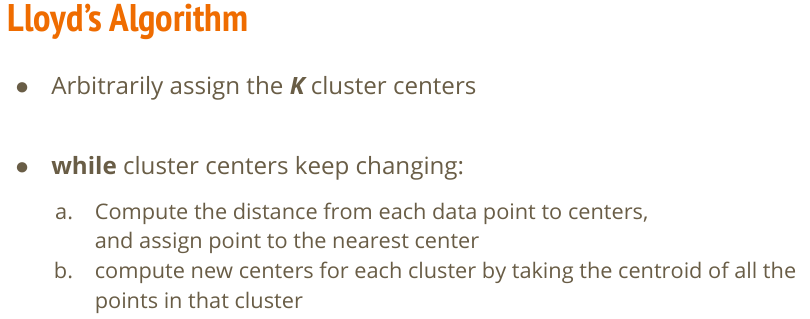

Алгоритм минимизирует функцию ошибки (**loss function**) вида

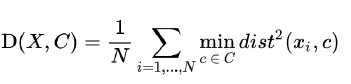

Расстояние между точками евклидово

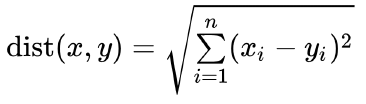

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Для проверки критерия сходимости можно использовать функцию `np.allclose(x, y)`

In [2]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.01)

False

In [3]:
np.allclose([[1,2,3], [1,2,3]], [[1,2,3], [1,2,2.95]], atol=0.1)

True

#### Загрузка данных

In [4]:
!wget -nv https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/flower.png

zsh:1: command not found: wget


In [5]:
# Загрузим картинку
img = plt.imread("flower.png")[:,:,:3]

# Теперь в переменной img находится трехмерный массив чисел. 
print(img.shape)

(427, 640, 3)


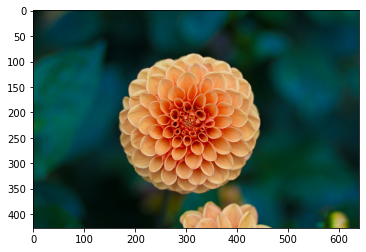

In [6]:
_ = plt.imshow(img)

In [7]:
# Цвет каждой точки задается трехмерным вектором в пространстве RGB. Это наши признаки.
print(img[400, 500])

[0.04313726 0.12156863 0.11372549]


In [8]:
# Преобразуем массив в двумерный. Теперь первая координата --- номер точки, вторая --- ее признаки 
X = img.reshape((-1,3))
print(X.shape)

(273280, 3)


#### Кластеризация

Примерная структура класса. Можно менять, если хотите

In [43]:
class KMeans(object):
    def __init__(self, n_clusters, max_iter, seed=0, tol=0.001):
        # число кластеров
        self.n_clusters = n_clusters 
        # максимальное число итераций (на случай, если будет долго сходиться)
        self.max_iter = max_iter     
        # array-like of shape (n_clusters, n_features) --- в эту переменную сохраняются координаты центроидов 
        self.centroids = None
        # массив со значениями функции ошибки на каждой итерации
        self.losses = []
        # зерно генератора случайных чисел
        self.seed = seed
        # точность, с которой мы смотрим на изменение положения центроидов
        self.tol = tol
        
    def distances(self, X):
        '''
        Returns distance from each sample to all centroids
        :param X: array-like of shape (n_samples, n_features) 
            Training instances to cluster 
        :return dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances
        '''
       
        def dist_func(a, b):
            if len(a) != len(b):
                raise Exception(f'not equal length {len(a)} {len(b)}')
            
            ret_value = 0
            for i in range(len(a)):
                ret_value += (a[i] - b[i]) ** 2
            
            return ret_value ** (0.5)
        
        if self.centroids is None:
            return np.array()
    
        n_samples = X.shape[0]
                
        dists = np.zeros((n_samples, self.n_clusters))
        for i in range(n_samples):
            for k in range(self.n_clusters):
                dists[i][k] = dist_func(X[i], self.centroids[k])
        
        return dists
    
    def loss(self, dist):
        '''
        :param dist: array-like of shape (n_samples, n_clusters)
            Matrix of distances 
        :return loss: float
            Value of the loss function
        '''
        
        n_samples = dist.shape[0]
        
        loss = 0
        for i in range(dist.shape[0]):
            loss += (dist[i].min()) ** 2
        
        return loss / n_samples
    
    def initialize(self, X):
        '''
        Initialize centroids
        :param X: array-like of shape (n_samples, n_features) 
            Training instances to cluster 
        
        '''
        indexes = np.random.choice(range(X.shape[0]), self.n_clusters)
        self.centroids = X[indexes, :]
        #self.centroids = np.random.uniform(low=0, high=255, size=(self.n_clusters, X.shape[1]))
    
    def fit_predict(self, X):
        '''
        Implements Lloyd's algorithm
        :param X: array-like of shape (n_samples, n_features) 
            Training instances to cluster   
        :return labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        '''
        # инициализируем генератор случайных чисел
        np.random.seed(self.seed)
        
        # инициализируем центроиды
        self.initialize(X)
        
        labels = np.zeros((X.shape[0]), dtype=int)
        
        for global_iter in range(self.max_iter):
            print('iteration: ', global_iter)
            dists = self.distances(X)
            
            self.losses.append(self.loss(dists))
            
            for i in range(labels.size):
                #print(labels[i], np.argmin(dists[i]))
                labels[i] = np.argmin(dists[i])
            
            new_centres = np.zeros((self.n_clusters, X.shape[1]))
            
            for cluster in range(self.n_clusters):
                indexes = [index for index in range(X.shape[0]) if labels[index] == cluster]
                
                for index in indexes:
                    new_centres[cluster] += X[index]
                
                new_centres[cluster] /= len(indexes)
            
            if (np.allclose(self.centroids, new_centres, atol=0.01)):
                self.centroids = new_centres
                break
                
            self.centroids = new_centres

        return labels

Запустим кластеризацию на наших данных

In [44]:
cls = KMeans(n_clusters=8, max_iter=7, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

iteration:  0
iteration:  1
iteration:  2
iteration:  3


Посмотрим, как убывала функция ошибки

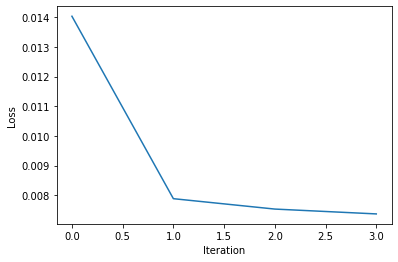

In [45]:
_ = plt.plot(losses)
_ = plt.xlabel('Iteration')
_ = plt.ylabel('Loss')

Наши центроиды -- цвета в пространстве RGB. Можно их нарисовать

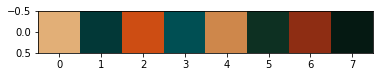

In [46]:
_ = plt.imshow([centroids])

Теперь сделайте из `X` матрицу `Y`, в которой координаты каждой точки заменены на координаты центроида

In [47]:
Y = [centroids[y_pred[i]] for i in range(X.shape[0])]

Посмотрим, что получилось

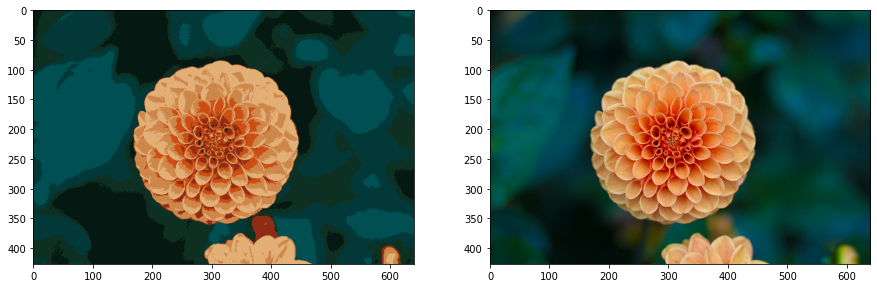

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

Поэкспериментируйте с разным числом кластеров

In [50]:
def experiment(n_clusters):
    cls = KMeans(n_clusters=n_clusters, max_iter=7, seed=0)
    y_pred = cls.fit_predict(X)
    losses = cls.losses
    centroids = cls.centroids
    Y = [centroids[y_pred[i]] for i in range(X.shape[0])]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    _ = ax1.imshow(np.array(Y).reshape(img.shape))
    _ = ax2.imshow(img)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4


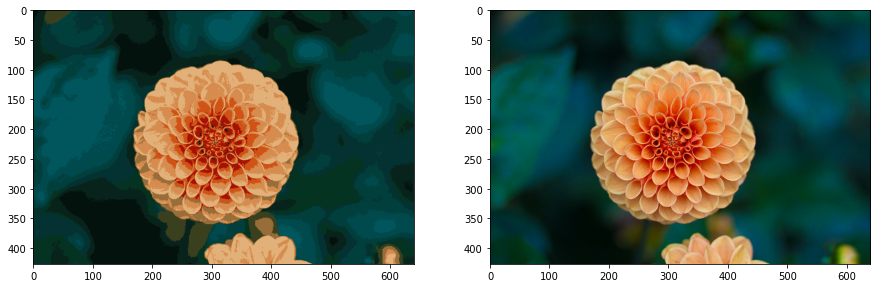

In [51]:
experiment(13)

### 1.2. Иерархическая кластеризация

Реализуйте алгоритм иерархической кластеризации

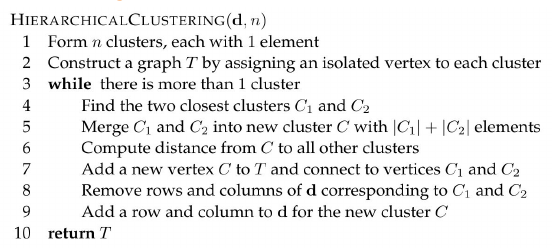

Для вычисления расстояний между кластерами используйте среднее расстояние между входящими в них точками:

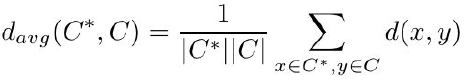



#### 1.2.1. Реализуйте функцию `distance_matrix`, вычисляющую матрицу попарных расстояний между точками. 
В качестве метрики мы будем использовать евклидово расстояние,

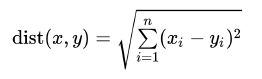


In [16]:
def distance_matrix(X):
    '''
    Compute matrix of pair-wise distances between samples
    :param X: array-like of shape (n_samples, n_features)
        Samples
    :return D: array-like of shape (n_samples, n_samples) 
        Matrix of pair-wise distances between samples
    '''
    D = 
    
    return D

#### 1.2.2. Реализуйте функцию `linkage`. 

На вход подается матрица расстояний. На выходе --- результат кластеризации в виде матрицы связей. Строки этой матрицы соответствуют операции объединения кластеров. Каждая строка имеет вид

```[C1, C2, dist(C1, C2), N]```

где `C1` и `C2` --- номера объединяемых кластеров, `dist(C1, C2)` --- расстояние между объединяемыми кластерами, `N` --- число точек в новом кластере

Например, кластеризации

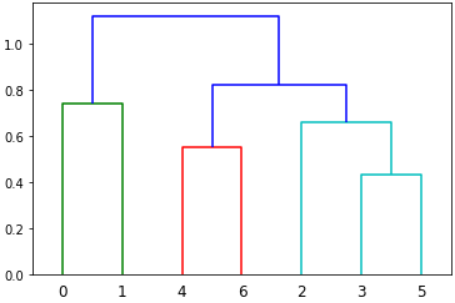

соответствует 
```
Z = [[ 3.    5.    0.43  2.  ]
     [ 4.    6.    0.55  2.  ]
     [ 2.    7.    0.66  3.  ]
     [ 0.    1.    0.74  2.  ]
     [ 8.    9.    0.82  5.  ]
     [10.   11.    1.12  7.  ]]
```


In [17]:
def linkage(D):
    '''
    :param D: array-like of shape (n_samples, n_samples) 
            Matrix of pair-wise distances between samples
    :return linkage: Linkage matrix
    '''
    D1 = D.copy()
    linkage = []
    clusters = []
    
    # your code goes here
    
    return linkage


####  Проверка 1

In [18]:
# Нам дана матрица расстояний
D = np.array([[0.  , 0.74, 0.85, 0.54, 0.83, 0.92, 0.89],
              [0.74, 0.  , 1.59, 1.35, 1.2 , 1.48, 1.55],
              [0.85, 1.59, 0.  , 0.63, 1.13, 0.69, 0.73],
              [0.54, 1.35, 0.63, 0.  , 0.66, 0.43, 0.88],
              [0.83, 1.2 , 1.13, 0.66, 0.  , 0.72, 0.55],
              [0.92, 1.48, 0.69, 0.43, 0.72, 0.  , 0.8 ],
              [0.89, 1.55, 0.73, 0.88, 0.55, 0.8 , 0.  ]])

# кластеризуем
Z = linkage(D)

# и напечатаем что получилось
print(np.array(Z))

[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]


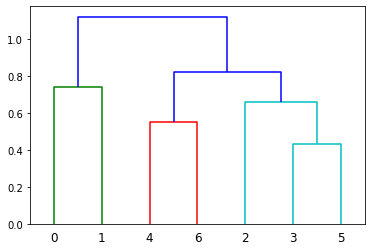

In [19]:
# для построения дендрограммы воспользуемся функцией из библиотеки scipy
from scipy.cluster.hierarchy import dendrogram

# должна получиться картинка из начала этого раздела
_ = dendrogram(Z)

####  Проверка 2

In [20]:
D = np.array([
    [0.  , 0.43, 0.93, 0.85, 0.94, 0.7 , 0.95, 0.79, 0.89, 1.34, 0.8 , 0.64, 1.42, 1.37, 0.86, 1.2 , 0.49, 0.19, 1.48, 0.86],
    [0.43, 0.  , 0.66, 0.7 , 1.48, 0.58, 0.7 , 0.55, 0.68, 1.45, 1.31, 0.37, 1.24, 1.69, 0.91, 1.28, 1.04, 0.29, 0.94, 1.05],
    [0.93, 0.66, 0.  , 1.01, 1.42, 0.8 , 0.76, 1.18, 0.21, 1.18, 1.35, 0.82, 0.68, 0.85, 0.75, 1.01, 0.93, 1.03, 0.6 , 0.91],
    [0.85, 0.7 , 1.01, 0.  , 1.02, 0.22, 0.89, 0.91, 0.79, 1.47, 1.04, 1.51, 0.71, 1.63, 0.34, 1.05, 1.24, 0.56, 1.09, 1.25],
    [0.94, 1.48, 1.42, 1.02, 0.  , 1.46, 1.48, 0.95, 1.44, 1.08, 0.3 , 1.29, 1.28, 0.65, 1.  , 0.8 , 0.8 , 0.92, 1.48, 0.65],
    [0.7 , 0.58, 0.8 , 0.22, 1.46, 0.  , 0.77, 1.  , 0.65, 1.25, 1.27, 1.36, 0.81, 1.56, 0.37, 0.98, 1.17, 0.68, 0.88, 1.23],
    [0.95, 0.7 , 0.76, 0.89, 1.48, 0.77, 0.  , 1.41, 1.08, 1.61, 1.65, 0.89, 0.76, 1.32, 0.64, 0.7 , 0.59, 1.07, 0.49, 0.91],
    [0.79, 0.55, 1.18, 0.91, 0.95, 1.  , 1.41, 0.  , 1.05, 0.73, 1.08, 0.7 , 1.49, 1.17, 1.  , 1.34, 1.45, 0.49, 1.06, 1.3 ],
    [0.89, 0.68, 0.21, 0.79, 1.44, 0.65, 1.08, 1.05, 0.  , 0.96, 1.09, 0.94, 0.44, 1.06, 0.9 , 1.47, 1.2 , 0.79, 1.04, 1.39],
    [1.34, 1.45, 1.18, 1.47, 1.08, 1.25, 1.61, 0.73, 0.96, 0.  , 0.96, 1.1 , 1.05, 0.48, 1.36, 1.26, 1.38, 1.38, 1.03, 1.38],
    [0.8 , 1.31, 1.35, 1.04, 0.3 , 1.27, 1.65, 1.08, 1.09, 0.96, 0.  , 1.08, 1.09, 0.79, 1.4 , 1.03, 1.02, 0.78, 1.79, 0.86],
    [0.64, 0.37, 0.82, 1.51, 1.29, 1.36, 0.89, 0.7 , 0.94, 1.1 , 1.08, 0.  , 1.42, 1.2 , 1.61, 1.3 , 0.86, 0.68, 1.04, 0.83],
    [1.42, 1.24, 0.68, 0.71, 1.28, 0.81, 0.76, 1.49, 0.44, 1.05, 1.09, 1.42, 0.  , 0.99, 0.84, 1.2 , 1.21, 1.22, 0.97, 1.58],
    [1.37, 1.69, 0.85, 1.63, 0.65, 1.56, 1.32, 1.17, 1.06, 0.48, 0.79, 1.2 , 0.99, 0.  , 1.13, 0.61, 1.  , 1.6 , 0.81, 0.83],
    [0.86, 0.91, 0.75, 0.34, 1.  , 0.37, 0.64, 1.  , 0.9 , 1.36, 1.4 , 1.61, 0.84, 1.13, 0.  , 0.68, 0.89, 0.86, 0.65, 1.04],
    [1.2 , 1.28, 1.01, 1.05, 0.8 , 0.98, 0.7 , 1.34, 1.47, 1.26, 1.03, 1.3 , 1.2 , 0.61, 0.68, 0.  , 0.92, 1.47, 0.47, 0.42],
    [0.49, 1.04, 0.93, 1.24, 0.8 , 1.17, 0.59, 1.45, 1.2 , 1.38, 1.02, 0.86, 1.21, 1.  , 0.89, 0.92, 0.  , 0.9 , 1.18, 0.49],
    [0.19, 0.29, 1.03, 0.56, 0.92, 0.68, 1.07, 0.49, 0.79, 1.38, 0.78, 0.68, 1.22, 1.6 , 0.86, 1.47, 0.9 , 0.  , 1.56, 1.21],
    [1.48, 0.94, 0.6 , 1.09, 1.48, 0.88, 0.49, 1.06, 1.04, 1.03, 1.79, 1.04, 0.97, 0.81, 0.65, 0.47, 1.18, 1.56, 0.  , 0.84],
    [0.86, 1.05, 0.91, 1.25, 0.65, 1.23, 0.91, 1.3 , 1.39, 1.38, 0.86, 0.83, 1.58, 0.83, 1.04, 0.42, 0.49, 1.21, 0.84, 0.  ]])

Выведите Linkage матрицу и постройте дендрограмму

[[ 0.         17.          0.19        2.        ]
 [ 2.          8.          0.21        2.        ]
 [ 3.          5.          0.22        2.        ]
 [ 4.         10.          0.3         2.        ]
 [14.         22.          0.355       3.        ]
 [ 1.         20.          0.36        3.        ]
 [15.         19.          0.42        2.        ]
 [ 9.         13.          0.48        2.        ]
 [ 6.         18.          0.49        2.        ]
 [12.         21.          0.56        3.        ]
 [11.         25.          0.56333333  4.        ]
 [ 7.         30.          0.6325      5.        ]
 [16.         26.          0.705       3.        ]
 [28.         32.          0.78166667  5.        ]
 [24.         29.          0.80666667  6.        ]
 [23.         27.          0.87        4.        ]
 [31.         34.          0.995      11.        ]
 [33.         36.          1.05890909 16.        ]
 [35.         37.          1.184375   20.        ]]


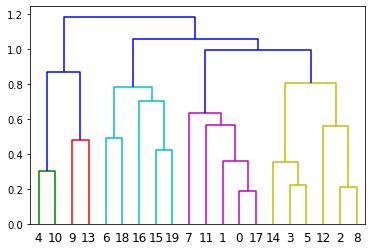

In [21]:

# your code here


### 1.2.3. Digits dataset

In [22]:
from sklearn import datasets

# загрузим датасет Digits. Он состоит из рукописных изображений цифр
digits = datasets.load_digits().images

In [23]:
# выберем 20 случайных изображений
digits = np.random.permutation(digits)[:20]

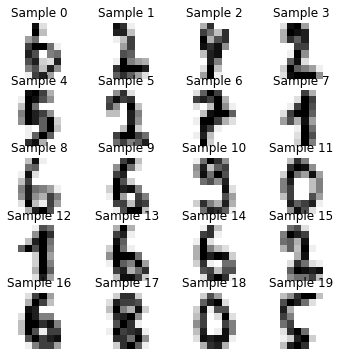

In [24]:
# вот они
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

In [25]:
# каждое изображение --- матрица размера (8, 8). Давайте вытянем ее в вектор признаков
XX = digits.reshape((digits.shape[0], -1))

**Кластеризуйте вектора и постройте дендрограмму. Какие выводы можно из нее сделать?**

In [ ]:

# your code here


**Выводы:**


## 2. Advanced

### 2.1. K-Means initialization

Качество кластеризации K-Means сильно зависит от начального выбора положения центроидов. Если центроиды выбраны неудачно, алгоритм может сходиться очень долго (или не сойтись вообще) и сойтись к решению, далекому от оптимального.

Попробуйте сделать работу вашего алгоритма более устойчивой:
* На этапе инициализации сделайте `n_init` инициализаций центроидов, и выберите лучшую
* Реализуйте K-Means++ http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

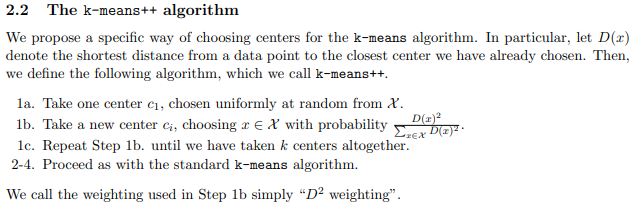

Сравните результат с обычным KMeans. Почему на одном наборе данных отличие может быть заметнее, чем на другом? Напишите свои мысли.

In [27]:
class KMeansPP(object):
    
    # your code here


Для сравнения можно использовать, например

In [28]:
!wget -nv https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/1.png
!wget -nv https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/3.png
!wget -nv https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/4.png    
!wget -nv https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/6.png
!wget -nv https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/7.png

2021-02-07 21:37:58 URL:https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/1.png [392511/392511] -> "1.png" [1]
2021-02-07 21:37:59 URL:https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/3.png [215767/215767] -> "3.png" [1]
2021-02-07 21:38:02 URL:https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/4.png [767861/767861] -> "4.png" [1]
2021-02-07 21:38:03 URL:https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/6.png [15981/15981] -> "6.png" [1]
2021-02-07 21:38:03 URL:https://gist.githubusercontent.com/azmtag/d3c239fcc419d0bec884d27a29d013f4/raw/7.png [3132/3132] -> "7.png" [1]


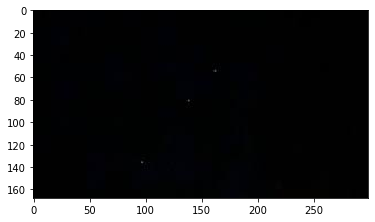

In [29]:
img = plt.imread("7.png")
_ = plt.imshow(img)

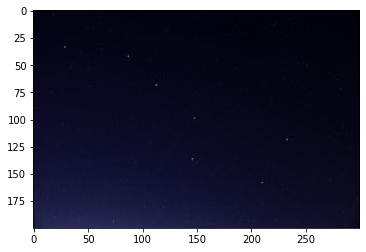

In [30]:
img = plt.imread("6.png")
_ = plt.imshow(img)

In [31]:

# your code goes here


### 2.2. Иерархическая кластеризация: Ward

Реализуйте другой метод для вычисления расстояний между кластерами,

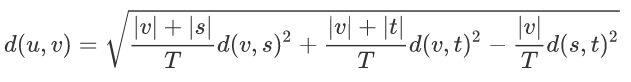

где *u* --- новый кластер, получающийся объединением *s* и *t*, *v* --- кластер, расстояние до которого мы хотим посчитать, *|u|* --- число точек в *u*, и *T = |v|+|s|+|t|*

Сравните результаты с UPGMA

In [32]:

# your code goes here
